In [1]:
# -*- coding: utf-8 -*-
# Licensed under a 3-clause BSD style license - see LICENSE.rst
import logging
import os
import warnings
from collections import OrderedDict
from multiprocessing import Pool

import astropy
from astropy.table import Table, hstack
import astropy.units as u
from astropy.io import ascii
from astropy.constants import alpha, c, e, hbar, m_e, m_p, sigma_sb
from astropy.utils.data import get_pkg_data_filename
from astropy.cosmology import WMAP9 as cosmo

import numpy as np
import matplotlib.pyplot as plt

from Validator import (
    validate_array,
    validate_physical_type,
    validate_scalar,
)
#from .model_utils import memoize
from Utils import trapz_loglog

import Models
import Radiative
import grbloader
from GRBmodel import GRBModel1
from GRBmodelstr import GRBModel_topstruc
from Models import EblAbsorptionModel

from astropy.units import def_physical_type

try:
    #def_physical_type(u.Unit("1 / eV"), "differential energy")
    def_physical_type(u.erg / u.cm**2 / u.s, "flux")
    def_physical_type(u.Unit("1/(s cm2 erg)"), "differential flux")
    def_physical_type(u.Unit("1/(s erg)"), "differential power")
    def_physical_type(u.Unit("1/TeV"), "differential energy")
    def_physical_type(u.Unit("1/cm3"), "number density")
    def_physical_type(u.Unit("1/(eV cm3)"), "differential number density")

except ValueError:
    print("New quantities already defined")

New quantities already defined


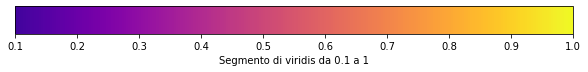

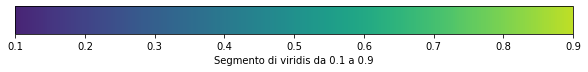

In [2]:
from matplotlib import cm
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

vmin = 0.1
vmax = 1
original_cmap = plt.cm.plasma

cmap1 = truncate_colormap(original_cmap, vmin, vmax)
fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)
norm = Normalize(vmin, vmax)  # da 0 a 1 perché stai solo mostrando il segmento
cb = ColorbarBase(ax,cmap=cmap1,norm=norm,orientation='horizontal')
cb.set_label(f'Segmento di viridis da {vmin} a {vmax}')
plt.show()

vmin = 0.1
vmax = 0.9
original_cmap2 = plt.cm.viridis

cmap2 = truncate_colormap(original_cmap2, vmin, vmax)
fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)
norm = Normalize(vmin, vmax)  # da 0 a 1 perché stai solo mostrando il segmento
cb = ColorbarBase(ax,cmap=cmap2,norm=norm,orientation='horizontal')
cb.set_label(f'Segmento di viridis da {vmin} a {vmax}')
plt.show()


In [3]:
############################################### PARAMETERS ####################################

Eiso = 8e51  # erg
density = 0.01 #0.5  # cm-3
redshift = 0.1
tstart = 68   # s
tstop = 110   # s

#-----list of parameters of a electron distribution (log10) ------

eta_e=-1.44
Ebreak=-1.62
Index2=3.3
Ec=1.32  # cutoff energy in TeV
B=0.25

#################################################################################################

the code can be used only for computation of theoretical curves
the code can be used only for computation of theoretical curves


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


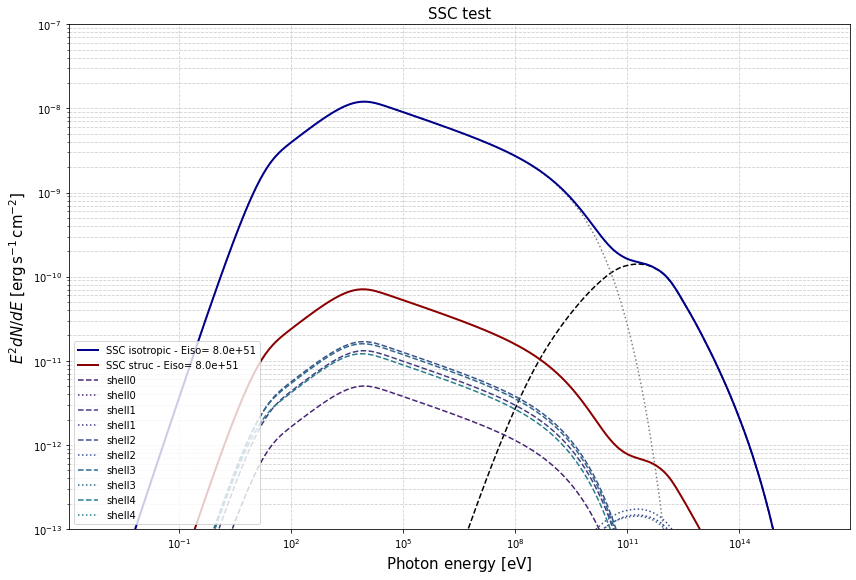

In [4]:
#multi_Eiso=np.logspace(49,52,10)
multi_Eiso = [8e51]

# Plot
plt.figure(figsize=(12,8))
plt.rc('font', family='sans')
plt.rc('mathtext', fontset='custom')

#plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync',c=cmap2(0.9))
color=0

for Eiso in multi_Eiso:
    
    grb = GRBModel1(eiso=Eiso, dens=density, tstart=tstart, tstop=tstop, redshift=redshift,
                        pars=[eta_e, Ebreak,Index2, Ec,  B],
                        labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=None)
    
    
    grb_struc= GRBModel_topstruc(eiso_zero=Eiso, dens=density, tstart=tstart, tstop=tstop, redshift=redshift,
                        pars=[eta_e, Ebreak,Index2, Ec,  B],
                        labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],
                        energy_profile='gaussian',shells=6, thetaend=10.0,
                        scenario='ISM',cooling_constrain=False,data=None)               
    emin=1e-3
    emax=1e16
    bins = int(np.log10(emax/emin) * 20.)  # use 20 bins per decade
    ener = Table([np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV], names=['energy'])  # energy in eV

    model= grb._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)
    model_str= grb_struc._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)

    SSC=model[1]
    SSC2=model_str[1]
    
    ymax=np.max(SSC).value
    ymin=np.min(SSC).value
    
    ordine = int(np.ceil(np.log10(ymax)))
    ymax = 10**ordine
    ymin = 10**(ordine - 6)
    
    #grb.plot_sed(1e-3,1e16,6)
    spectrum_energy=np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV
    
    plt.loglog(spectrum_energy,grb.ic_comp,lw=1.5,ls='--',c="black")
    plt.loglog(spectrum_energy,grb.synch_comp,lw=1.5,ls=':',c="gray")
    plt.loglog(spectrum_energy,SSC,lw=2,label=f'SSC isotropic - Eiso= {"{:.1e}".format(Eiso)}',c="darkblue")
    plt.loglog(spectrum_energy,SSC2,lw=2,label=f'SSC struc - Eiso= {"{:.1e}".format(Eiso)}',c="darkred")
    
    for i in range(0,5):
        

        plt.loglog(spectrum_energy,grb_struc.synch_comp[i,:],lw=1.5,ls='--',c=cmap2(color),label=f'shell{i}')
        plt.loglog(spectrum_energy,grb_struc.ic_comp[i,:],lw=1.5,ls=':',c=cmap2(color),label=f'shell{i}')
        color=color+0.1

plt.xlabel('Photon energy [{0}]'.format(spectrum_energy.unit.to_string('latex_inline')),fontsize=15)
plt.ylabel('$E^2 dN/dE$ [{0}]'.format(model[0].unit.to_string('latex_inline')),fontsize=15)

plt.ylim(ymin, ymax)
#plt.xlim(1e-3,5e16)
plt.tight_layout()
plt.legend(loc='lower left')


plt.title(f"SSC test",fontsize=15)
print("")
plt.grid(True, which="both", linestyle="--", alpha=0.6)

#plt.savefig("/media/tobiazenbook/PortableSSD/JOB/Projects/GRB-modelling/Plots-April30/plot1", format="jpg", dpi=300)
plt.show()

In [6]:
grb.print_GRB_status()

grb_struc.print_GRB_status()


#spèkxèskè+akc+akc


###############################   GRB status - START   #########################################

Isotropic Energy: 8e+51 erg
Ambient density around the burst units of cm-3: 0.01
Average evaluation time: 89.0 s
Redshift: 0.1
Luminosity Distance: 465.2805915046128 Mpc
Scenario: ISM
Magnetic field B: 1.7782794100389228 G
eta e: 0.03630780547701014
eta B: 0.3914496729462883
---------------------------------------------------------------------------------------
Gamma factor (Boosting): 103.39689877485736
Radius of the shell: 7.395e-02 pc or 2.282e+12 km
Dept of the shell: 7.947e-05 pc or 2.452e+09 km
Volume of the shell: 5.462e-06 pc3 or 1.605e+35 km3
Shock energy density (omega): 0.32142836986986584 erg
Minimum injection energy for the particle distribution: 1148417304.059714 eV
Total energy in the electrons: 1.8727991990588392e+48 erg

###############################   GRB status - END   #########################################


###############################   Structured GRB status 

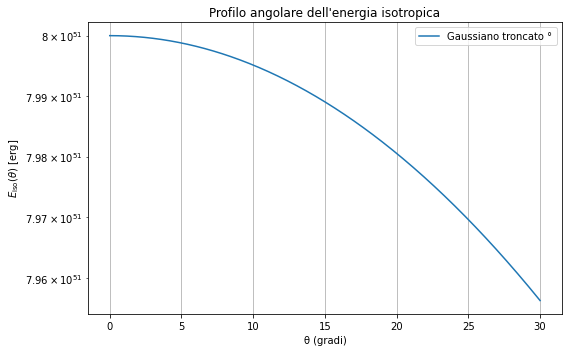

In [7]:
grb_struc.plot_jet_profile()

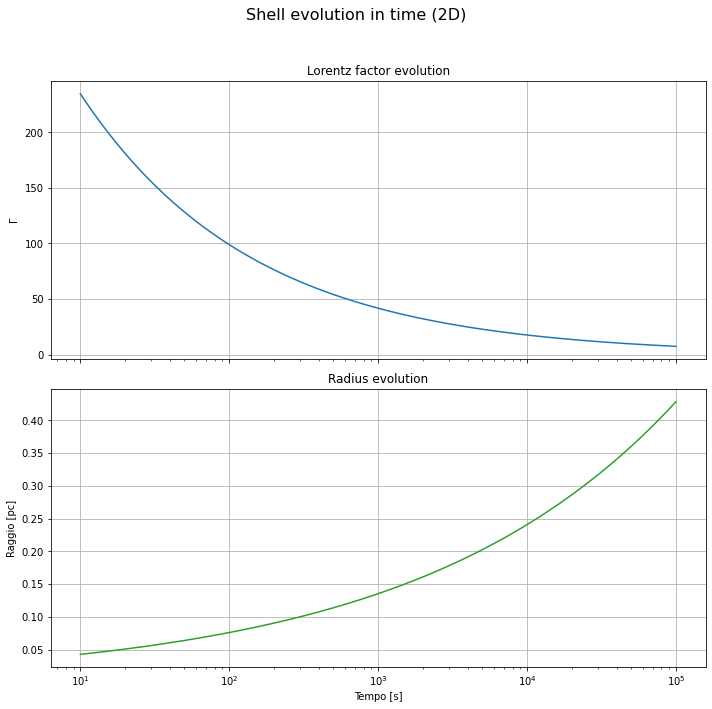

In [10]:
grb.plot_gamma_radius_vs_time(tmin=10, tmax=1e5, num=300)

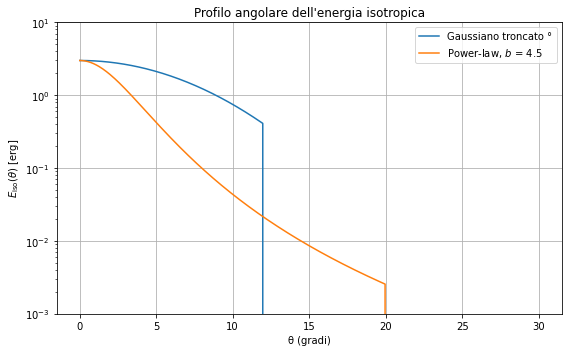

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri
Eiso_zero = 3                # erg


# Angoli da 0 a 90 gradi
theta = np.linspace(0, np.radians(30), 500)

# Funzione con truncazione
def E_theta_gaussian(theta, Eiso_zero, thetacore_deg, thetaw_deg):
    thetacore = np.radians(thetacore_deg)
    thetaw = np.radians(thetaw_deg)
    E = np.zeros_like(theta)
    inside = theta <= thetaw
    E[inside] = Eiso_zero * np.exp(-(theta[inside]**2) / (2 * thetacore**2))
    return E
# Modello power-law (senza troncamento)

def E_theta_powerlaw(theta, Eiso_zero, thetacore_deg,thetaw_deg,b):
    thetacore = np.radians(thetacore_deg)
    thetaw = np.radians(thetaw_deg)
    E = np.zeros_like(theta)
    inside = theta <= thetaw
    E[inside] =Eiso_zero * (1 + (theta[inside]**2) / (b * thetacore**2))**(-b/2)
    return E

# Calcolo e plot
E = E_theta_gaussian(theta, Eiso_zero, 6, 12)
E_powerlaw = E_theta_powerlaw(theta, Eiso_zero, 2,20, b=4.5)

plt.figure(figsize=(8,5))
plt.plot(np.degrees(theta), E, label=r"Gaussiano troncato °" )
plt.plot(np.degrees(theta), E_powerlaw, label=fr"Power-law, $b$ = {4.5}")
#plt.axvline(thetaw_, color='gray', linestyle='--', label=r"Troncamento $\theta_w$")
plt.xlabel("θ (gradi)")
plt.ylabel(r"$E_{\mathrm{iso}}(\theta)$ [erg]")
plt.title("Profilo angolare dell'energia isotropica")
plt.yscale("log")
plt.ylim(1e-3, 1e1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
